# Water Pumps Functionality Analysis In Tanzania

Using data from Tanzanian Ministry of Water, our goal is to predict if water pumps are functional or non-functional.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate , GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , accuracy_score,recall_score,f1_score,precision_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline
warnings.filterwarnings("ignore")

## EDA

In [5]:
df1 = pd.read_csv('data/Training Set Values.csv')
df2 = pd.read_csv('data/Training Set Labels.csv')
pd.set_option('display.max_columns',None)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We are going to merge our data together so that we have one dataframe with predictors and target values.

In [7]:
all_data = df1.merge(df2, on='id')

In [8]:
all_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Data Cleaning

We are going to drop unneccessary features.

In [9]:
all_data.drop(['id', 'wpt_name', 'recorded_by', 'num_private', 'funder', 'installer', 'public_meeting'], axis=1, inplace=True)

Now we are going to see if there are duplicates of the columns.

We are going to drop scheme_name since scheme_management has more specific values.

We are going to drop waterpoint_type_group since waterpoint_type has more specific values.

We are going to drop extraction_type_class and extraction_type_group since extraction_type has more specific values.

We are going to drop source_type since source has more specific values.

We are going to drop payment_type since payment has more specific values.

We are going to drop quantity_group since quantity has more specific values.

We are going to drop management_group since management has more specific values.

In [10]:
all_data.drop(['waterpoint_type_group', 'scheme_name', 'extraction_type_class', 'extraction_type_group',
                'source_type',  'payment_type', 'quantity_group', 'management_group'
                ], axis=1, inplace=True)

We want to just get the year from the date_recorded and drop date_recorded.

In [11]:
all_data['recorded_year'] = all_data['date_recorded'].str[:4].astype(int)

We kept lat, long, region_code, district_code for location based information and droped region, subvillage, lga, and ward.

In [12]:
all_data.drop(['date_recorded', 'region', 'subvillage', 'lga', 'ward'], axis=1, inplace=True)

Let's look for null values.

In [13]:
all_data.isna().sum()

amount_tsh              0
gps_height              0
longitude               0
latitude                0
basin                   0
region_code             0
district_code           0
population              0
scheme_management    3877
permit               3056
construction_year       0
extraction_type         0
management              0
payment                 0
water_quality           0
quality_group           0
quantity                0
source                  0
source_class            0
waterpoint_type         0
status_group            0
recorded_year           0
dtype: int64

In [14]:
# Fill null values to 'unknown' since scheme_management and permit are object
all_data.fillna('Unknown', inplace=True)

In [15]:
# Change permit type boolean to string
all_data['permit'] = all_data['permit'].astype(str)

In [16]:
all_data.isna().sum()

amount_tsh           0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
district_code        0
population           0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment              0
water_quality        0
quality_group        0
quantity             0
source               0
source_class         0
waterpoint_type      0
status_group         0
recorded_year        0
dtype: int64

Now all our data is cleaned for modeling.

### Functions

We created functions to help us visualize our data.

In [17]:
#makes a copy of df that has not been converted to binary values for target
df_binary = all_data.copy()

# Apply the binary function to our target.
binary_key = {'functional': 0,'functional needs repair': 0, 'non functional': 1}
df_binary['status_group'].replace(binary_key, inplace=True)

In [92]:
# Some functions that may provide to be useful
def mean_scores(results):
    '''Return Train/Test Mean Score from a Cross Val'''
    return print(f'''Mean Train Score: {results['train_score'].mean()}
Mean Test Score: {results['test_score'].mean()}''')

def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds)}
Precision Score: {precision_score(y_true,y_preds)}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds)}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')

def gs_mean_scores(results):
    '''Return Train and Test Scores from a grid search'''
    return print(f'''Mean Train Score: {results.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {results.cv_results_['mean_test_score'].mean()}''')

def total_val_count(df,column):
    '''Creates a dictionary with all value counts in column'''
    data= df[column]
    counts = {}
    for i in data:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
    return counts_sorted

def val_count_nf(df,column):
    '''Creates a dictionary from a dataframe that has columns
    as keys and their total count of values that do not have functioning pumps'''
    df_val = df.loc[df['status_group'] == 1]
    counts = {}
    for i in df_val[column]:
        counts[i] = counts.get(i, 0) + 1
    counts_sorted = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
    return counts_sorted


def addlabels(x,y,left,up):
    '''Add labels on top of each bar on bar graph'''
    for i in range(len(x)):
        plt.text(i-left,y[i]+up,y[i])

def addlabelsbig(x,y,left,up):
    '''Add BIGGER labels on top of each bar on bar graph'''
    for i in range(len(x)):
        plt.text(i-left,y[i]+up,f'{y[i]}%',fontsize=20,color='black')

def percent_dict(df,column):
    '''Creates a dictionary that has highest percent of non functioning pumps'''
    percent= []
    lst = list(df[column].unique())
    for val in lst:
        num_pumps = len(df1.loc[df[column] == val])
        fail_pumps = len(df1.loc[(df['status_group'] == 1) & (df[column] == val)])
        percent.append(round((fail_pumps/num_pumps*100),2))
    d = dict(zip(lst,percent))
    d_sorted = dict(sorted(d.items(), key=lambda item: item[1],reverse=True))
    return d_sorted

def visualize(dictionary,title=None):
    '''Creates Seaborn Barplot from Dictionary'''
    nums = list(dictionary.values())
    fig , ax = plt.subplots(figsize=(12,10))
    sns.barplot(x=list(dictionary.keys()),y=nums)
    ax.set_title(title,fontsize=15)
    ax.set_ylabel('Percent Non Functioning',fontsize=15);

def stack_it(df,column,title=None,addlabels=False):
    '''Returns Barplot showing total count of catgory type with percent of failure '''

    fig , ax= plt.subplots(nrows=1,ncols=1,figsize=(12,8))
    
    
    column_count = total_val_count(df,column)
    nums = list(column_count.values())[:5]
    top_5 = list(column_count.keys())[:5]
    transform = val_count_nf(df,column)
    num_failed = []
    for x in top_5:
        for y in transform.keys():
            if x == y:
                num_failed.append(transform[y])
    percent_failed = [round((i / j)*100,1) for i, j in zip(num_failed, nums)]
    
    ax.set_title(title,fontsize=15)
    sns.barplot(x=top_5,y=nums,alpha=.4,label='Total Count',color='orange')
    ax.set_ylabel('Total Count',fontsize=15)
    sns.barplot(x=top_5, y=num_failed,label='Amount Failed',color='orange')
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    if addlabels:        
        addlabelsbig(top_5,percent_failed,.2,100);

### Data Visualization

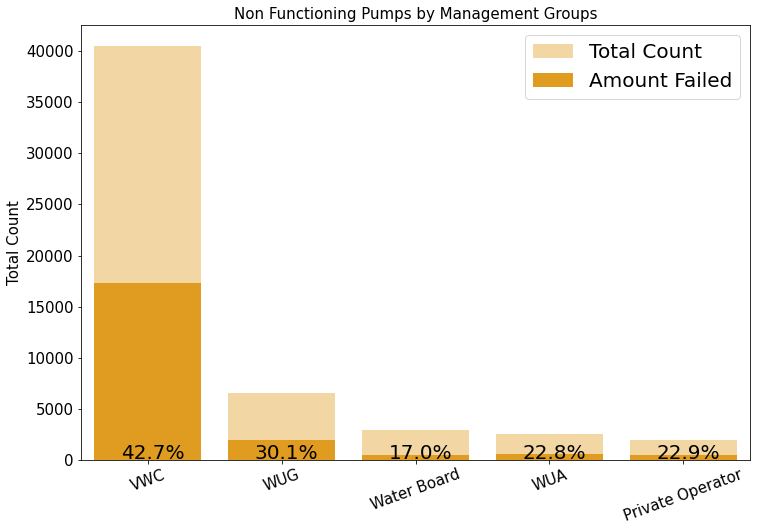

In [19]:
stack_it(df_binary,'management',addlabels=True,title='Non Functioning Pumps by Management Groups')
plt.legend(fontsize=20)
plt.xticks([0, 1, 2, 3 ,4], ['VWC', 'WUG', 'Water Board', 'WUA', 'Private Operator'],
    rotation=20);

Here we are speculating that how a waterpoint is managed may have an impact on the percentage of failed pumps. VWC seems to be leading the way with almost 43% non functioning pumps at their waterpoints.

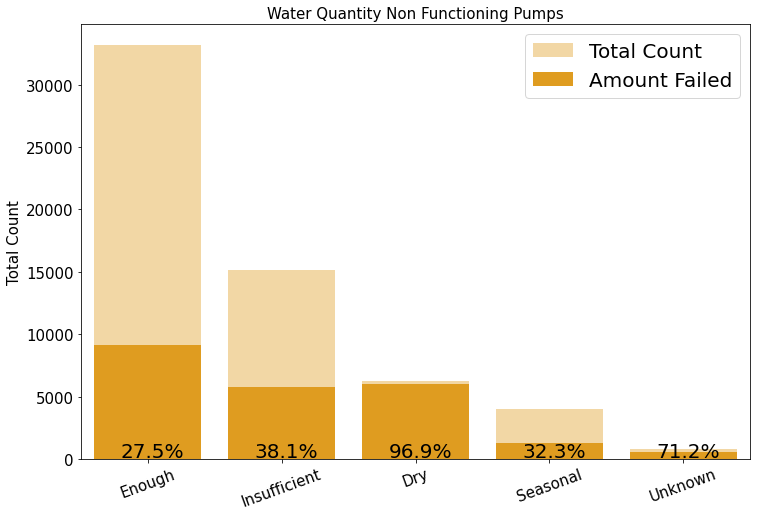

In [20]:
stack_it(df_binary,'quantity',addlabels=True,title='Water Quantity Non Functioning Pumps')
plt.xticks([0, 1, 2, 3 ,4], ['Enough', 'Insufficient', 'Dry', 'Seasonal', 'Unknown'],
    rotation=20)
plt.legend(fontsize=20);

Well this is very interesting. Dry areas have the highest amount of broken pumps, at just about 97%. It is also interesting that waterpoints labeled as insufficient water have the second highest rate of broken pumps. It seems the less water a waterpoint has, the higher the chance the pump is non functioning.

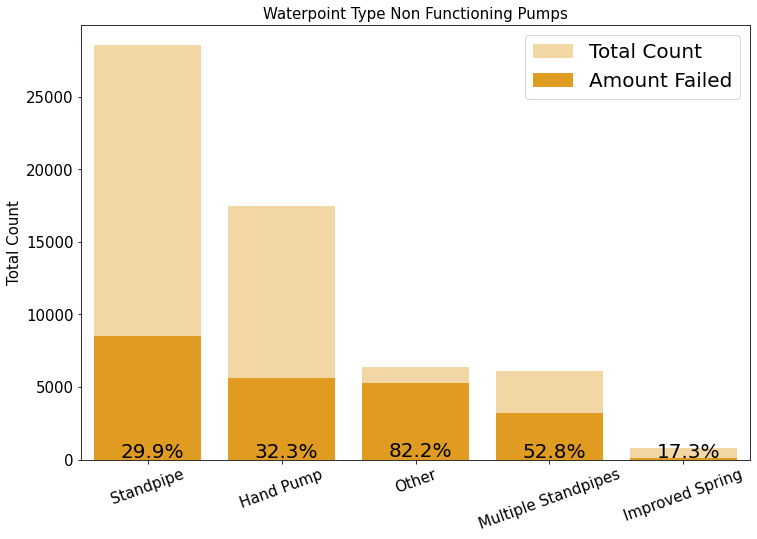

In [21]:
stack_it(df_binary,'waterpoint_type',addlabels=True,title='Waterpoint Type Non Functioning Pumps')
plt.legend(fontsize=20)
plt.xticks([0, 1, 2, 3 ,4], ['Standpipe','Hand Pump','Other','Multiple Standpipes','Improved Spring'],
    rotation=20);

A single standpipe seems to be a good indicator of whether or not a pump will stop working. If a waterpoint has multiple standpoints, there is over a 50% chance that the pump will not be functioning. It would be nice if the 'Other' category could be identified to see which pumps are performing the worst.

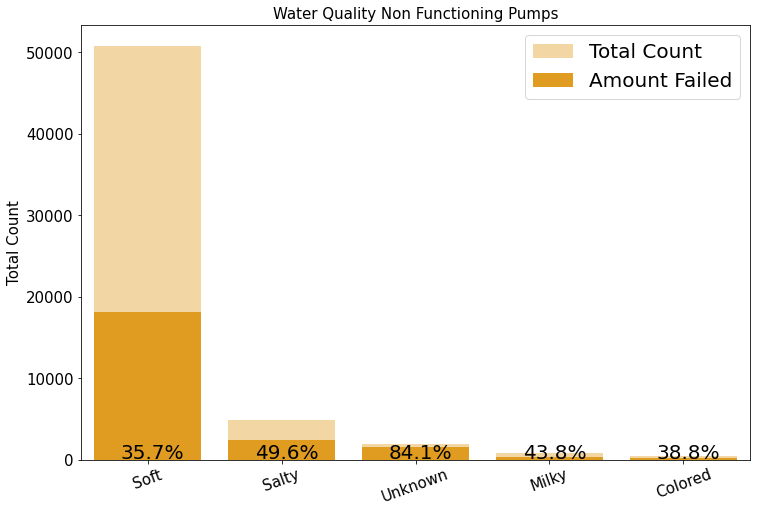

In [22]:
stack_it(df_binary,'water_quality',title='Water Quality Non Functioning Pumps',addlabels=True)
plt.legend(fontsize=20)
plt.xticks([0, 1, 2, 3 ,4], ['Soft','Salty','Unknown','Milky','Colored'],
    rotation=20);

Here we see salt water has the highest percent of failures. We would expect water with higher solid contents (such as saltwater) to have a high percent of failures because of the wear and tear caused by the solids in the water. 

Unknown water types take the lead for failures. It would be interesting to see the solid content percent of those unknown water types, as we think more solids in the water leads to more failures. Other things (like flow rates) would affect the failures also. The faster the solids move in water, the more damage they will do to pumps!  

## Model Selection

### Train-Test Split

In [23]:
X = all_data.drop('status_group', axis=1)
y = all_data['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

We want to bin our target values to binary.

In [24]:
y_train = y_train.map({'functional' : 0, 'non functional' : 1, 'functional needs repair' : 0})

Then, we want to make an age column to get the age of the water pumps.

In [25]:
# Replace water pumps with 0 construction year with the median construction year
median_year_with_no_zero = X_train[X_train['construction_year'] > 0]['construction_year'].median()
X_train.loc[(X_train['construction_year'] == 0),'construction_year'] = median_year_with_no_zero

# If construction year is greater than recorded age, than replace construction year with median year.
X_train.loc[(X_train['construction_year'] > X_train['recorded_year']),'construction_year'] = median_year_with_no_zero

# Create age column
X_train['age'] = X_train['recorded_year'] - X_train['construction_year']

# Drop recorded_year and construction_year since we now have the age
X_train.drop(['recorded_year', 'construction_year'], axis=1, inplace=True)

### Dummy Classifier

Using Dummy Classifier, we are going to come up with our First Simple Model.

In [26]:
y_train.value_counts(normalize=True)

0    0.615758
1    0.384242
Name: status_group, dtype: float64

We see that our classes aren't imbalanced. We have approximately 60% functional and approximately 40% non-functional.

In [27]:
# Create our dummy model
dummy_model = DummyClassifier(strategy="most_frequent")

cv_results = cross_validate(dummy_model, X_train, y_train, return_train_score=True)

In [32]:
mean_scores(cv_results)

Mean Train Score: 0.6157575757575758
Mean Test Score: 0.6157575757575758


The dummy model gives a result of ~61.6% accurate results.

### Logistic Regression

Now, we are going to try logistic regression model on our data to see if there is an improvement.

In [33]:
# Get categorical and numeric columns
categorical_cols = X_train.select_dtypes('object')
numerical_cols = X_train.select_dtypes(exclude=['object'])

# Make Pipeline for categorical (OneHotEncoder) and numeric columns (StandardScaler)
categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

# Create transformer with both categorical and numeric pipelines
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Create a pipeline with the transformer and the model
lr_pipline = Pipeline(steps=[('trans', trans),
                              ('model', LogisticRegression(random_state=42))])

In [34]:
# Create a grid search to get the best hypterparameter for logistic regression
lr_grid = {'model__C' : [0.5, 1, 50],
       'model__max_iter' : [1750, 2000],
       'model__class_weight': [None, 'balanced', 0.25],
       'model__tol' : [0.0001, 0.01, 0.1]}

lr_gs = GridSearchCV(lr_pipline, lr_grid, cv=3, return_train_score=True)

In [35]:
# Fit our data into the grid search
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'age'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index([...n_type', 'management

In [23]:
# See the best parameters for logistic regression
lr_gs.best_params_

{'model__C': 1,
 'model__class_weight': None,
 'model__max_iter': 1750,
 'model__tol': 0.0001}

In [41]:
gs_mean_scores(lr_gs)

Mean Train Score: 0.7929812528577963'
Mean Test Score: 0.7913829654570398


Our logistic regression model got ~79% accurate results. Looking at the train and test scores, the variance is low. Our bias is lower than our dummy model but not too low.

In [48]:
lr_y_pred = cross_val_predict(lr_gs.best_estimator_, X_train, y_train)

metrics(y_train,lr_y_pred)

Recall Score: 0.5986096506601238
Precision Score: 0.8191701974578304
Accuracy Score:0.7949943883277216
F1 Score: 0.6917338913828602
Confusion Matrix: 
[[25170  2262]
 [ 6871 10247]]


The logistic model predicts 35,417 water pumps correctly. The model also predicts 6,871 water pumps as non-functional when they are functional and it preditcs 2,238 water pumps as functional when they are non-functional.

### KNN

Let's see if KNN gives us a better result.

In [49]:
gs_mean_scoresCreate pipeline with the transformer and KNN model
knn_pipline = Pipeline(steps=[('trans', trans),
                              ('model', KNeighborsClassifier())])

In [50]:
# Create grid search to get the best parameters for KNN
knn_grid= {'model__n_neighbors': [7,11,15,21],
      'model__weights': ['distance', 'uniform'],
      }

knn_gs = GridSearchCV(knn_pipline, knn_grid, cv=3, return_train_score=True)

# Fit our training data in the grid search
knn_gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'age'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_manage

In [51]:
# Get our best parameter for KNN
knn_gs.best_params_

{'model__n_neighbors': 15, 'model__weights': 'distance'}

In [57]:
gs_mean_scores(knn_gs)

Mean Train Score: 0.9180331088664422'
Mean Test Score: 0.8168237934904602


Our KNN model got ~81.6% accurate results. Looking at the train and test scores, the variance is high. Our bias is slightly lower than our logistic but it seems like our KNN model is overfit.

In [58]:
knn_y_pred = cross_val_predict(knn_gs.best_estimator_, X_train, y_train)

metrics(y_train, knn_y_pred)

Recall Score: 0.7315106905012267
Precision Score: 0.8131168831168831
Accuracy Score:0.8322334455667789
F1 Score: 0.7701580663017406
Confusion Matrix: 
[[24554  2878]
 [ 4596 12522]]


The knn model predicts 37,076 water pumps correctly. The model also predicts 4,596 water pumps as non-functional when they are functional and it preditcs 2,878 water pumps as functional when they are non-functional.

### Random Forest Classifier

Let's see if RandomForestClassifier gives us a better result.

In [60]:
# Create transformers for only OneHotEncoder since forest doesn't need scaler
ohe_trans = ColumnTransformer(transformers=[('categorical', categorical_pipeline, categorical_cols.columns)],
                              remainder='passthrough')
# Create pipeline with transformer and randomforest model
forest_pipline = Pipeline(steps=[('ohe_trans', ohe_trans),
                              ('model', RandomForestClassifier(random_state=42))])

In [61]:
# Create grid search to get the best hyperparameters for randomforest
forest_grid= {'model__criterion':['gini', 'entropy'],
         'model__max_depth':[None,3,5],
         'model__min_samples_split':[2,5,10],
         'model__min_samples_leaf':[1,3,5,7],
         'model__max_features' : [5,10]}

forest_gs = GridSearchCV(forest_pipline, forest_grid, cv=3, return_train_score=True)

# Fit the training data in the grid search
forest_gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_management', 'permit', 'extraction_type', 'management',
       'payment', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model

In [62]:
# Look at best hyperparameters
forest_gs.best_params_

{'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 10,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5}

In [65]:
gs_mean_scores(forest_gs)

Mean Train Score: 0.8008793178700587'
Mean Test Score: 0.7836664484349669


Our random forest classifier model got ~78% accurate results. Looking at the train and test scores, the variance is low. Our bias is higher than than the knn model and logistic model.

In [94]:
forest_y_pred = cross_val_predict(forest_gs.best_estimator_, X_train, y_train)

metrics(y_train, forest_y_pred)

Recall Score: 0.7574483000350508
Precision Score: 0.8454616588419406
Accuracy Score:0.8536026936026936
F1 Score: 0.7990386393048622
Confusion Matrix: 
[[25062  2370]
 [ 4152 12966]]


The random forest classifier model predicts 38,028 water pumps correctly. The model also predicts 4,152 water pumps as non-functional when they are functional and it preditcs 2,370 water pumps as functional when they are non-functional.

### XGBoost

Let's see if XGBoost gives us a better result.

In [69]:
# Create pipeline with transformer and XGBoost model
xgb_pipeline = Pipeline(steps=[('ohe_trans', ohe_trans),
                               ('model', XGBClassifier(random_state=42))])

In [70]:
# Create grid search to find the best  
xgb_grid = {'model__n_estimators':[50,75,100],
            'model__max_depth':[1,3,4,5]}

xgb_gs = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_grid, cv=3, return_train_score=True)

# Fit the training data to the grid search
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_management', 'permit', 'extraction_type', 'management',
       'payment', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_class', 'wate...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                           

In [80]:
# Get the best parameter from grid search
xgb_gs.best_params_

{'model__max_depth': 5, 'model__n_estimators': 100}

In [84]:
gs_mean_scores(xgb_gs)

Mean Train Score: 0.8267433595211373'
Mean Test Score: 0.813791619902731


Our XGBoost model got ~81% accurate results. Looking at the train and test scores, the variance is low. Our bias is lower than the dummy, logistic, and forest model. XGBoost model has low bias and low variance, so we want to work with this model.

With this model, we want to try to get a better score.

#### Tweaking the hyperparameters

To get better score, we are going to make changes to the hyperparameters.

In [82]:
xgb_grid2 = {'model__n_estimators':[150,200,225,240],
            'model__max_depth':[4,5,6,7]}

xgb_gs2 = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_grid2, cv=3, return_train_score=True)

xgb_gs2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['basin', 'scheme_management', 'permit', 'extraction_type', 'management',
       'payment', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_class', 'wate...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                           

In [83]:
xgb_gs2.best_params_

{'model__max_depth': 7, 'model__n_estimators': 200}

In [87]:
gs_mean_scores(xgb_gs2)

Mean Train Score: 0.9066813973063973'
Mean Test Score: 0.8427272727272728


The second XGBoost model with changed hyperparameters got ~84% accurate results. Looking at the train and test scores, the variance is higher than other models but the bias is lower than all the other models.

In [97]:
xgb_y_pred = cross_val_predict(xgb_gs2.best_estimator_, X_train, y_train)

metrics(y_train, xgb_y_pred)

Recall Score: 0.7386376913190793
Precision Score: 0.8458656676478459
Accuracy Score:0.8478563411896746
F1 Score: 0.7886234641052828
Confusion Matrix: 
[[25128  2304]
 [ 4474 12644]]


The XGBoost model predicts 37,772 water pumps correctly. The model also predicts 4,474 water pumps as non-functional when they are functional and it preditcs 2,304 water pumps as functional when they are non-functional.

## Best Model - XGBoost

Our last XGBoost gave the best test score with hyperparameters of 'model__max_depth': 7, 'model__n_estimators': 200. So we will check to see how the XGBoost model predicts on our testing data.

In [100]:
# Make our target binary, create age column, and drop year_recorded and construction_year
y_test = y_test.map({'functional' : 0, 'non functional' : 1, 'functional needs repair' : 0})
median_year_with_no_zero = X_test[X_test['construction_year'] > 0]['construction_year'].median()
X_test.loc[(X_test['construction_year'] == 0),'construction_year'] = median_year_with_no_zero
X_test.loc[(X_test['construction_year'] > X_test['recorded_year']),'construction_year'] = median_year_with_no_zero
X_test['age'] = X_test['recorded_year'] - X_test['construction_year']
X_test.drop(['recorded_year', 'construction_year'], axis=1, inplace=True)

In [101]:
# Get accuracy score for the best model
xgb_gs2.score(X_test, y_test)

0.857979797979798

The best model's accuracy score is ~85.8%.

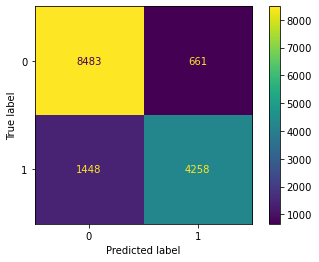

In [102]:
plot_confusion_matrix(xgb_gs2, X_test, y_test)

The XGBoost model predicts 12,741 water pumps in the testing data correctly. The model also predicts 1,448water pumps as non-functional when they are functional and it preditcs 661 water pumps as functional when they are non-functional.

#### Feature Importance

With the best model, we want to check which features were most impactful.

In [103]:
best_model = xgb_gs2.best_estimator_.fit(X_train, y_train)

In [104]:
# Get column names including onehotencoded columns
ohe_col_names = list(best_model.named_steps['ohe_trans'].transformers_[0][1][0].get_feature_names(categorical_cols.columns))

# Combine onehotencoded columsn with numeric columns
col_names = ohe_col_names + list(numerical_cols.columns)

In [105]:
col_names

['basin_Internal',
 'basin_Lake Nyasa',
 'basin_Lake Rukwa',
 'basin_Lake Tanganyika',
 'basin_Lake Victoria',
 'basin_Pangani',
 'basin_Rufiji',
 'basin_Ruvuma / Southern Coast',
 'basin_Wami / Ruvu',
 'scheme_management_Company',
 'scheme_management_None',
 'scheme_management_Other',
 'scheme_management_Parastatal',
 'scheme_management_Private operator',
 'scheme_management_SWC',
 'scheme_management_Trust',
 'scheme_management_Unknown',
 'scheme_management_VWC',
 'scheme_management_WUA',
 'scheme_management_WUG',
 'scheme_management_Water Board',
 'scheme_management_Water authority',
 'permit_False',
 'permit_True',
 'permit_Unknown',
 'extraction_type_afridev',
 'extraction_type_cemo',
 'extraction_type_climax',
 'extraction_type_gravity',
 'extraction_type_india mark ii',
 'extraction_type_india mark iii',
 'extraction_type_ksb',
 'extraction_type_mono',
 'extraction_type_nira/tanira',
 'extraction_type_other',
 'extraction_type_other - mkulima/shinyanga',
 'extraction_type_other -

In [106]:
# Create a dataframe with the feature names and the importance of each feature for a better look
feature_importance_df = pd.DataFrame({'Features' : col_names, 'Importances' : best_model[1].feature_importances_})
feature_importance_df

,Features,Importances
0,basin_Internal,0.004314
1,basin_Lake Nyasa,0.024857
2,basin_Lake Rukwa,0.020311
3,basin_Lake Tanganyika,0.002254
4,basin_Lake Victoria,0.003165
...,...,...
104,latitude,0.003433
105,region_code,0.009339
106,district_code,0.004833
107,population,0.003331


In [107]:
# Features with importances that are greater than 0.025
feature_importance_df[feature_importance_df['Importances'] > 0.025].sort_values(by=['Importances'], ascending=False)

,Features,Importances
76,quantity_dry,0.281667
100,waterpoint_type_other,0.129326
43,management_company,0.026243


We can see from the dataframe that the feature quantity_dry had the biggest impact, ~28.2%, and waterpoint_type_other had the second biggest impact on the model, ~12.9%.

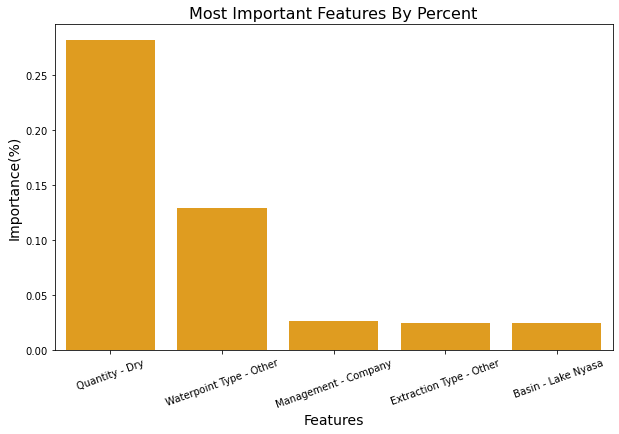

In [115]:
df_top_important = feature_importance_df.sort_values(by=['Importances'], ascending=False)[:5]
fig, ax = plt.subplots(figsize=(10,6))

x = ['Quantity - Dry', 'Waterpoint Type - Other', 'Management - Company', 'Extraction Type - Other', ' Basin - Lake Nyasa']

ax = sns.barplot(x, df_top_important['Importances'], color='orange')
ax.set_title('Most Important Features By Percent', fontsize=16)
ax.set_ylabel('Importance(%)', fontsize=14)
ax.set_xlabel('Features', fontsize=14)
plt.xticks(rotation=20);

# Conclusion

Our final model, XGBoost, gave us ~85% accuracy of predicting the functionality of the water pump.

Our recommendations are:

* Perform regular checks of water quantity for all pumps 

* Replace ‘other’ waterpoint types with gravity waterpoint types

* Check who manages the water
